# Purpose of the Project:
1. Learn to harness AI for recognizing human emotional states.
Grasp the fundamental concepts and reasoning behind the design of residual neural networks.
2. Create and train artificial neural network models using Google Colab, taking advantage of powerful GPU and TPU resources.
3. Construct, train, evaluate, and apply resnets for categorizing images with datasets from the real world.
4. Utilize image augmentation techniques to enhance the model's ability to generalize.
5. Assess the performance of resnet models on test data using a variety of key performance indicators.
6. Comprehend the distinctions between the Sigmoid function and the ReLU activation function.
7. Employ the Keras API along with TensorFlow 2.0 to develop complex convolutional neural networks.
8. Understand the differences between the metrics of precision and recall.
9. Execute combined predictions using models that identify key facial points and classify facial expressions.
10. Implement and use deep neural networks with TensorFlow 2.0 for making predictions.

Artificial Emotional Intelligence or Emotion AI allows computers to understand non verbal cues such as body movements and facial expressions.

This project has an overarching classification problem: to classify people's emotions based on their facial expressions in their face images. We have over 20,000 facial images, with their associated facial expression labels and about 2,000 images with their primary facial notations.

As a result, we are going to train an emotional AI model which would parse through an original input image and make two predictions:
1. The emotion reflected on the person's face (anger/happiness/sadness etc.), and
2. Key facial points ((x,y) coordinates of facial features such as eyes, nose, mouth, etc.)

Using these two predictions, we will get the combined predictions of the people's emotions.

# Part 1: Primary Facial Features Points Detection
In this section, we will create a deep learning model based on CNNs and Residual Blocks to predict where the primary facial features are located.

We have a dataset with gray-scale images of 96x96 pixels consisting of the x and y coordinates of the 15 facial features.

In [ ]:
#import relevant packages. We will use tensorflow 2.0 and keras API to build and train our models.
import pandas as pd
import numpy as np
import os
import PIL
import seaborn as sns
import pickle
from PIL import *
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.python.keras import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow

In [ ]:
#Load facial features coordinates data
facial_features = pd.read_csv('/content/data.csv')

In [ ]:
facial_features
#'Image' column contains the values for the pixels for the actual image

left_eye_center_x  left_eye_center_y  right_eye_center_x  \
0             66.033564          39.002274           30.227008   
1             64.332936          34.970077           29.949277   
2             65.057053          34.909642           30.903789   
3             65.225739          37.261774           32.023096   
4             66.725301          39.621261           32.244810   
...                 ...                ...                 ...   
1547          66.373479          35.182356           29.817863   
1548          65.746578          35.691574           30.064340   
1549          67.404283          34.655354           29.991111   
1550          65.109802          36.858374           29.968527   
1551          65.460124          39.225072           29.359835   

      right_eye_center_y  left_eye_inner_corner_x  left_eye_inner_corner_y  \
0              36.421678                59.582075                39.647423   
1              33.448715                58.856170                35.274349   
2              34.909642                59.412000                36.320968   
3              37.261774                60.003339                39.127179   
4              38.042032                58.565890                39.621261   
...                  ...                      ...                      ...   
1547           38.478247                58.583014                36.680548   
1548           35.551805                58.470419                35.831635   
1549           35.539071                61.217616                35.833859   
1550           35.048791                57.569055                36.858374   
1551           37.713814                57.400412                40.232577   

      left_eye_outer_corner_x  left_eye_outer_corner_y  \
0                   73.130346                39.969997   
1                   70.722723                36.187166   
2                   70.984421                36.320968   
3                   72.314713                38.380967   
4                   72.515926                39.884466   
...                       ...                      ...   
1547                74.163945                36.380712   
1548                74.982128                36.671125   
1549                74.474343                36.128323   
1550                75.064264                38.065231   
1551                74.359093                39.896742   

      right_eye_inner_corner_x  right_eye_inner_corner_y  ...  nose_tip_y  \
0                    36.356571                 37.389402  ...   57.066803   
1                    36.034723                 34.361532  ...   55.660936   
2                    37.678105                 36.320968  ...   53.538947   
3                    37.618643                 38.754115  ...   54.166539   
4                    36.982380                 39.094852  ...   64.889521   
...                        ...                       ...  ...         ...   
1547                 37.009315                 38.777753  ...   57.055562   
1548                 36.921191                 36.111465  ...   53.742492   
1549                 37.650424                 36.128323  ...   54.687677   
1550                 39.621275                 36.104440  ...   58.275165   
1551                 38.762557                 39.225072  ...   57.527093   

      mouth_left_corner_x  mouth_left_corner_y  mouth_right_corner_x  \
0               61.195308            79.970165             28.614496   
1               56.421447            76.352000             35.122383   
2               60.822947            73.014316             33.726316   
3               65.598887            72.703722             37.245496   
4               60.671411            77.523239             31.191755   
...                   ...                  ...                   ...   
1547            64.575781            75.333370             33.713096   
1548            63.927538            68.435161             31.463781   
1549  

In [ ]:
#Get information about counts and data types of the features
facial_features.info()
#Looks like there are no null elements. The data type for each column is float64, except for 'Image'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          2140 non-null   float64
 1   left_eye_center_y          2140 non-null   float64
 2   right_eye_center_x         2140 non-null   float64
 3   right_eye_center_y         2140 non-null   float64
 4   left_eye_inner_corner_x    2140 non-null   float64
 5   left_eye_inner_corner_y    2140 non-null   float64
 6   left_eye_outer_corner_x    2140 non-null   float64
 7   left_eye_outer_corner_y    2140 non-null   float64
 8   right_eye_inner_corner_x   2140 non-null   float64
 9   right_eye_inner_corner_y   2140 non-null   float64
 10  right_eye_outer_corner_x   2140 non-null   float64
 11  right_eye_outer_corner_y   2140 non-null   float64
 12  left_eyebrow_inner_end_x   2140 non-null   float64
 13  left_eyebrow_inner_end_y   2140 non-null   float

In [ ]:
#Check if null elements in the dataset
facial_features.isnull().sum()
#no null elements in the data

left_eye_center_x            0
left_eye_center_y            0
right_eye_center_x           0
right_eye_center_y           0
left_eye_inner_corner_x      0
left_eye_inner_corner_y      0
left_eye_outer_corner_x      0
left_eye_outer_corner_y      0
right_eye_inner_corner_x     0
right_eye_inner_corner_y     0
right_eye_outer_corner_x     0
right_eye_outer_corner_y     0
left_eyebrow_inner_end_x     0
left_eyebrow_inner_end_y     0
left_eyebrow_outer_end_x     0
left_eyebrow_outer_end_y     0
right_eyebrow_inner_end_x    0
right_eyebrow_inner_end_y    0
right_eyebrow_outer_end_x    0
right_eyebrow_outer_end_y    0
nose_tip_x                   0
nose_tip_y                   0
mouth_left_corner_x          0
mouth_left_corner_y          0
mouth_right_corner_x         0
mouth_right_corner_y         0
mouth_center_top_lip_x       0
mouth_center_top_lip_y       0
mouth_center_bottom_lip_x    0
mouth_center_bottom_lip_y    0
Image                        0
dtype: int64

In [ ]:
#Check the number of instances for the 'Image' column
facial_features['Image'].shape

(2140,)

In [ ]:
#The values for the pixels of each image are listed as space-separated strings. So, we will separate the values using ' ' as separator.
#We will then convert the instances of this feature into a numpy array and then convert the 1D array into a 2D array of shape (96,96).
facial_features['Image'] = facial_features['Image'].apply(lambda x: np.fromstring(x, dtype = int, sep=' ').reshape((96,96)))

In [ ]:
facial_features['Image'][0].shape #shape of the first image as a sample

(96, 96)

MINI CHALLENGE:
Obtain the average, minimum, and maximum values for column 'right_eye_center_x'

In [ ]:
print("Average value for right_eye_center_x: " , facial_features['right_eye_center_x'].mean(axis = 0))
print("Minimum value for right_eye_center_x: ", min(facial_features['right_eye_center_x']))
print("Maximum value for right_eye_center_x: ", max(facial_features['right_eye_center_x']))

Average value for right_eye_center_x:  29.640268564561495
Minimum value for right_eye_center_x:  18.9226106286
Maximum value for right_eye_center_x:  42.495171727


In [ ]:
#You can just use .describe() to get the summary statistics of the data
facial_features.describe()

left_eye_center_x  left_eye_center_y  right_eye_center_x  \
count        2140.000000        2140.000000         2140.000000   
mean           66.221549          36.842274           29.640269   
std             2.087683           2.294027            2.051575   
min            47.835757          23.832996           18.922611   
25%            65.046300          35.468842           28.472224   
50%            66.129065          36.913319           29.655440   
75%            67.332093          38.286438           30.858673   
max            78.013082          46.132421           42.495172   

       right_eye_center_y  left_eye_inner_corner_x  left_eye_inner_corner_y  \
count         2140.000000              2140.000000              2140.000000   
mean            37.063815                59.272128                37.856014   
std              2.234334                 2.005631                 2.034500   
min             24.773072                41.779381                27.190098   
25%             35.818377                58.113054                36.607950   
50%             37.048085                59.327154                37.845220   
75%             38.333884                60.521492                39.195431   
max             45.980981                69.023030                47.190316   

       left_eye_outer_corner_x  left_eye_outer_corner_y  \
count              2140.000000              2140.000000   
mean                 73.412473                37.640110   
std                   2.701639                 2.684162   
min                  52.947144                26.250023   
25%                  71.741978                36.102409   
50%                  73.240045                37.624207   
75%                  74.978684                39.308331   
max                  87.032252                49.653825   

       right_eye_inner_corner_x  right_eye_inner_corner_y  ...   nose_tip_x  \
count               2140.000000               2140.000000  ...  2140.000000   
mean                  36.603107                 37.920852  ...    47.952141   
std                    1.822784                  2.009505  ...     3.276053   
min                   24.112624                 26.250023  ...    24.472590   
25%                   35.495730                 36.766783  ...    46.495330   
50%                   36.620735                 37.920336  ...    47.900511   
75%                   37.665280                 39.143921  ...    49.260657   
max                   47.293746                 44.887301  ...    65.279654   

        nose_tip_y  mouth_left_corner_x  mouth_left_corner_y  \
count  2140.000000          2140.000000          2140.000000   
mean     57.253926            63.419076            75.887660   
std       4.528635             3.650131             4.438565   
min      41.558400            43.869480            57.023258   
25%      54.466000            61.341291            72.874263   
50%      57.638582            63.199057            75.682465   
75%      60.303524            65.302398            78.774969   
max      75.992731            84.767123            94.673637   

       mouth_right_corner_x  mouth_right_corner_y  mouth_center_top_lip_x  \
count           2140.000000           2140.000000             2140.000000   
mean              32.967365             76.134065               48.081325   
std                3.595103              4.259514                2.723274   
min                9.778137             56.690208               32.260312   
25%               30.879288             73.280038               46.580004   
50%               33.034022             75.941985               47.939031   
75%               35.063575             78.884031               49.290000   
max               50.973348             93.443176               61.804506   

       mouth_center_top_lip_y  mouth_center_bottom_lip_x  \
count             2140.000000                2140.000000   
mean                72.681125                  48.149654

# Perform Image Visualization

Let us begin by plotting a random image from the dataset with the facial coordinates using plt.imshow()

We have 15 x and y coordinates for each image. Since the x coordinates are in even columns and y coordinates are in odd coluns, we will access their value using .loc command based on the referred columns

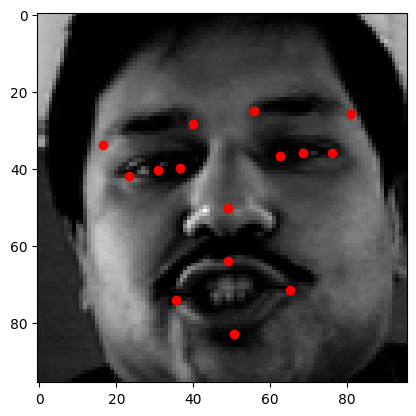

In [ ]:
i = np.random.randint(1, len(facial_features))
plt.imshow(facial_features['Image'][i], cmap='gray')
for j in range(1, 31, 2):
  plt.plot(facial_features.loc[i][j-1], facial_features.loc[i][j], 'ro')


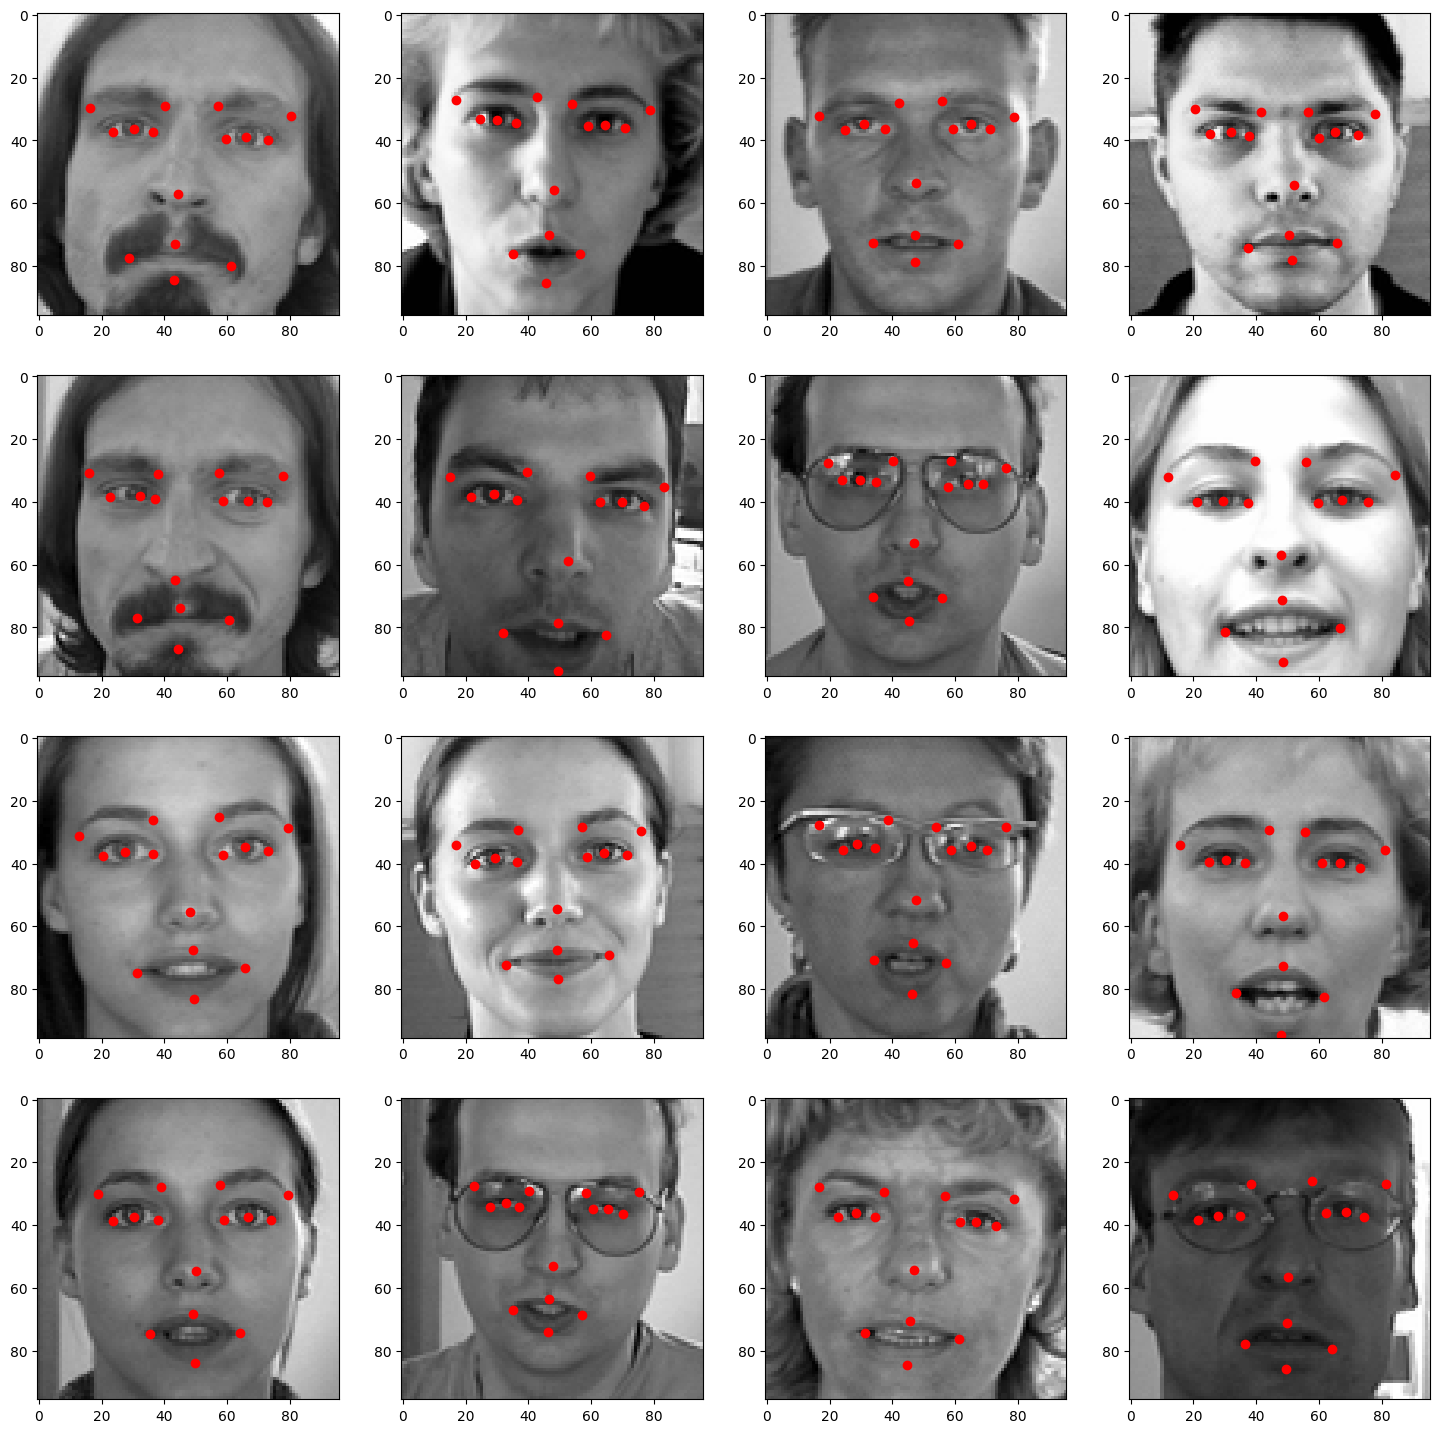

In [ ]:
#Viewing more images in a grid format:
fig = plt.figure(figsize = (18,18))
for i in range(16):
  ax = fig.add_subplot(4,4,i+1)
  image = plt.imshow(facial_features['Image'][i], cmap='gray')
  for j in range(1, 31, 2):
    plt.plot(facial_features.loc[i][j-1], facial_features.loc[i][j], 'ro')

MINI CHALLENGE: Perform a sanity check on the data by randomly visualizing 64 new images along with their corresponding key points

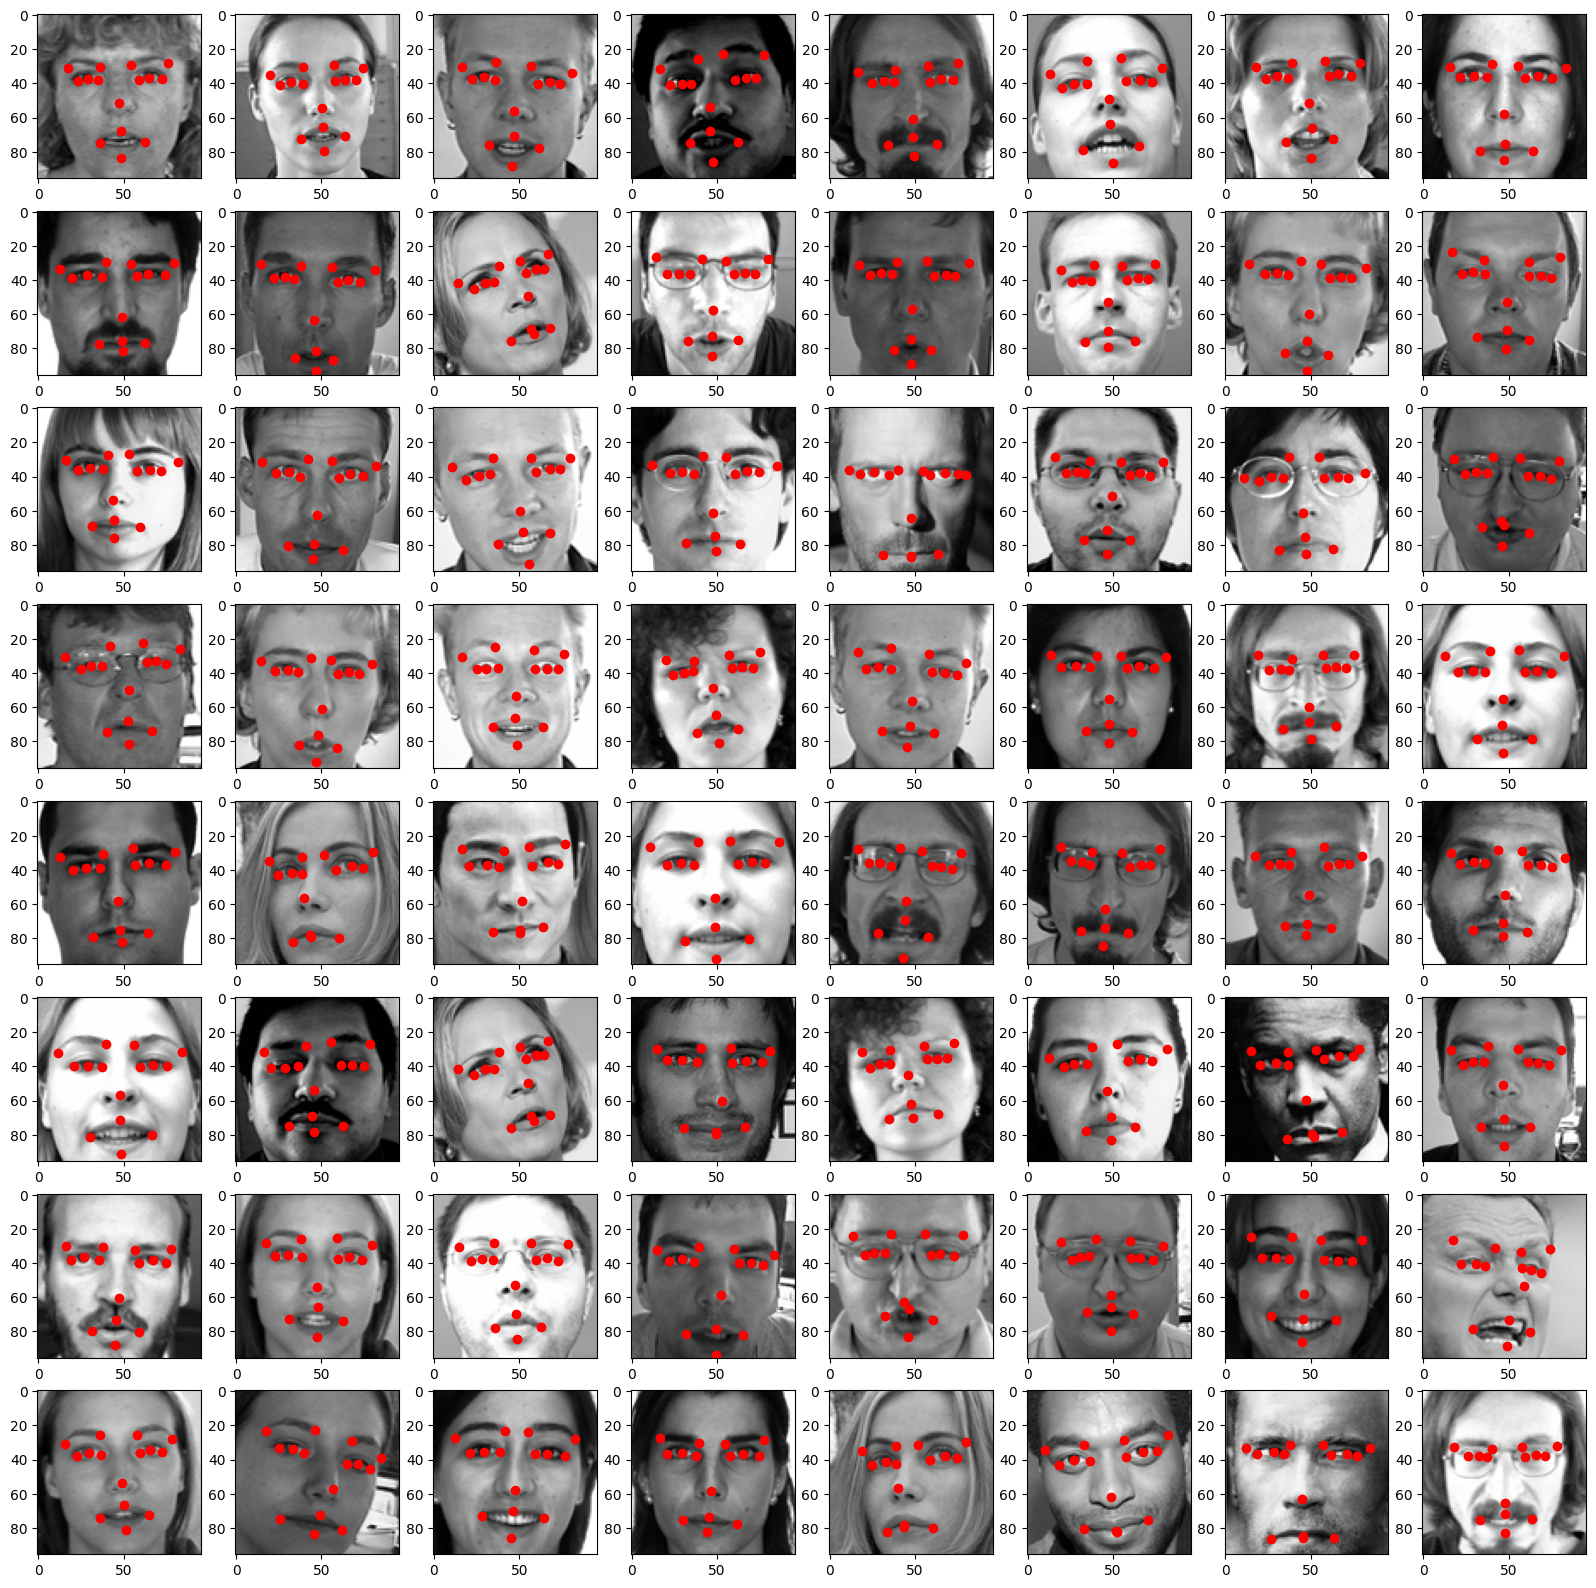

In [ ]:
#Viewing more images in a grid format:
import random
fig = plt.figure(figsize = (20,20))
for i in range(64):
  k = random.randint(1, len(facial_features))
  ax = fig.add_subplot(8,8,i+1)
  image = plt.imshow(facial_features['Image'][k], cmap='gray')
  for j in range(1, 31, 2):
    plt.plot(facial_features.loc[k][j-1], facial_features.loc[k][j], 'ro')

# Perform Image Augmentation
We want to create an additional dataset with images flipped horizontally and vertically, images in increased brightness and darkness, and images zoomed in and zoomed out. Such a dataset will enable us to improve the generalization capability of the model. We want our AI model to see everything we cannot - so the more data, the better.

In [ ]:
#Create a copy of the dataframe
import copy
facial_features_aug = copy.copy(facial_features)

In [ ]:
#Get the columns of the copied dataframe and get all the data except the images
columns = facial_features_aug.columns[:-1]
columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')

In [ ]:
#We will now flip the images horizontally, along the y axis
facial_features_aug['Image'] = facial_features_aug['Image'].apply(lambda x: np.flip(x, axis = 1))
#Due to the horizontal flipping, the y-coordinates would remain the same. We would need to change the x-coordinates such that we subtract our initial x-coordinates
#from the width of the image
for i in range(len(columns)):
  if i%2 == 0:
    facial_features_aug[columns[i]] = facial_features_aug[columns[i]].apply(lambda x: 96-float(x))

Original Image:


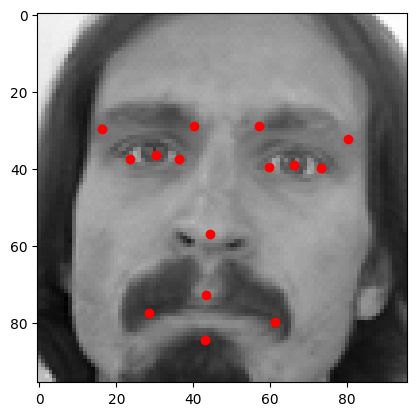

In [ ]:
#Display the original image (taking the first image as an example)
print("Original Image:")
plt.imshow(facial_features['Image'][0], cmap='gray')
for j in range(1, 31, 2):
  plt.plot(facial_features.loc[0][j-1], facial_features.loc[0][j], 'ro')

Horizontally Flipped Image


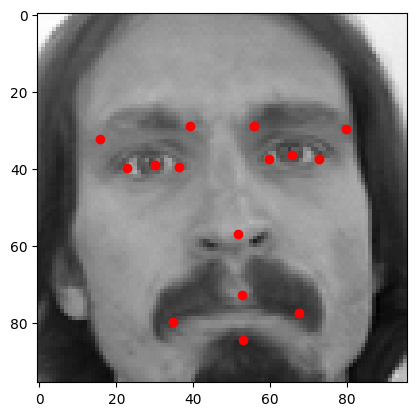

In [ ]:
#Display the horizontally flipped image (taking the first image as an example)
print("Horizontally Flipped Image")
plt.imshow(facial_features_aug['Image'][0], cmap='gray')
for j in range(1, 31, 2):
  plt.plot(facial_features_aug.loc[0][j-1], facial_features_aug.loc[0][j], 'ro')

In [ ]:
#Concatenated the original and horizontally flipped image dataset
augmented_dataset = np.concatenate([facial_features, facial_features_aug])

In [ ]:
augmented_dataset.shape

(4280, 31)

We will now work towards the brightness of the images by multiplying the pixel values between 1.5-2. We will also cap the values to be between 0 and 255.

In [ ]:
import copy
facial_features_aug = copy.copy(facial_features)
facial_features_aug['Image'] = facial_features_aug['Image'].apply(lambda x: np.clip(x*random.uniform(1.5, 2), 0, 255))
#Concatenate this again to augmented_dataset
augmented_dataset = np.concatenate([augmented_dataset, facial_features_aug])

In [ ]:
augmented_dataset.shape

(6420, 31)

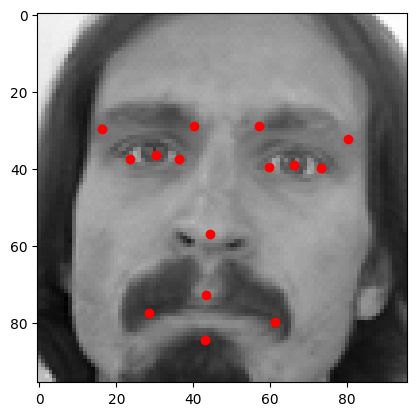

In [ ]:
#Show original image:
plt.imshow(facial_features['Image'][0], cmap='gray')
for j in range(1, 31,2):
  plt.plot(facial_features.loc[0][j-1], facial_features.loc[0][j], 'ro')

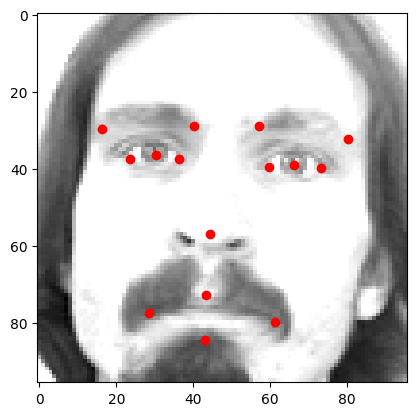

In [ ]:
#Show image with increased brightness
plt.imshow(facial_features_aug['Image'][0], cmap='gray')
for j in range(1, 31,2):
  plt.plot(facial_features_aug.loc[0][j-1], facial_features_aug.loc[0][j], 'ro')

MINI CHALLENGE: Augment images by flipping them vertically (so if we flip along the x axis, the x-coordinates would not change)

In [ ]:
facial_features_aug = copy.copy(facial_features)
#We will now flip the images vertically, along the y axis
facial_features_aug['Image'] = facial_features_aug['Image'].apply(lambda x: np.flip(x, axis = 0))
#Due to the vertical flipping, the x-coordinates would remain the same. We would need to change the y-coordinates such that we subtract our initial x-coordinates
#from the width of the image
for j in range(len(columns)):
  if j%2 == 1:
    facial_features_aug[columns[j]] = facial_features_aug[columns[j]].apply(lambda x: 96-float(x))

Original Image:


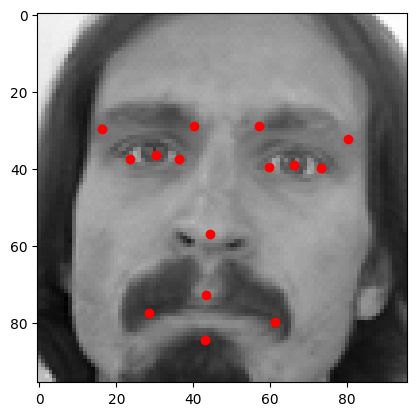

In [ ]:
#Display the original image (taking the first image as an example)
print("Original Image:")
plt.imshow(facial_features['Image'][0], cmap='gray')
for j in range(1, 31, 2):
  plt.plot(facial_features.loc[0][j-1], facial_features.loc[0][j], 'ro')

Vertically Flipped Image


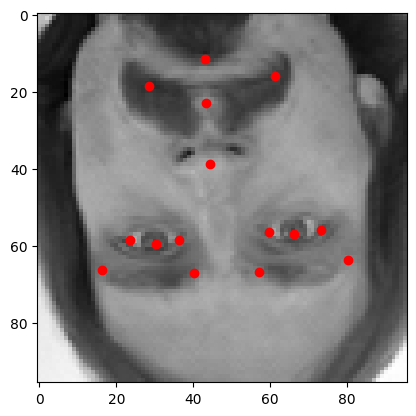

In [ ]:
#Display the vertically flipped image (taking the first image as an example)
print("Vertically Flipped Image")
plt.imshow(facial_features_aug['Image'][0], cmap='gray')
for j in range(1, 31, 2):
  plt.plot(facial_features_aug.loc[0][j-1], facial_features_aug.loc[0][j], 'ro')

In [ ]:
augmented_dataset.shape

(6420, 31)

# Perform Data Normalization and Training Data Preparation
We will take the pixel values and make them range between 0 and 1 for normalization and training of the neural networks

In [ ]:
# Obtain the value of images which is present in the 31st column (since index start from 0, we refer to 31st column by 30)
img = augmented_dataset[:,30]

# Normalize the images
img = img/255.

# Create an empty array of shape (x, 96, 96, 1) to feed the model
X = np.empty((len(img), 96, 96, 1))

# Iterate through the img list and add image values to the empty array after expanding its dimension from (96, 96) to (96, 96, 1)
for i in range(len(img)):
    # Assuming each img[i] is a flattened array of 96*96 = 9216 pixels
    X[i,] = np.expand_dims(img[i], axis = 2) # Expand dims to 3D (96, 96, 1)

# Convert the array type to float32
X = np.asarray(X).astype(np.float32)
X.shape

(6420, 96, 96, 1)

In [ ]:
#Preparing output: y
#We will first get the values of x and y coordinates which are used as the target
y = augmented_dataset[:,:30]
y = np.asarray(y).astype(np.float32)
y.shape

(6420, 30)

In [ ]:
#Split the data into train and test data - 80% training 20% testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
print(X_train.shape)
print(X_test.shape)

(5136, 96, 96, 1)
(1284, 96, 96, 1)


# Build Deep Residual Neural Network Facial Feature Detection Model
We would use TensorFlow 2.0 and the Keras API to build our model.

1. As CNNs continue to grow deeper, the gradient tends to vanish, hampering network performance. The vanishing gradient occurs when the gradient is back-propogated to ther previous layers, resulting in a minute gradient.
2. ResNets 'skip connection,' enabling the training of layers without causing the vanishing gradient issue.
3. ResNets work on top on CNNs using the addition of 'identity mappings.'
4. Here, we will be using ImageNet to train the ResNet deep neural network.

In the ResNets model, we will have the following components:
1. Convolutional Block: Here, we will have a main path, followed by a short path. We will add both of them to get the ReLu activation function.
2. Identity Block 1: This will perform identity mapping and will include the conv2D, BatchNormalization, and Activation.
3. Identity Block 2: This will also perform Conv2D, BatchNormalization, and Activation and eventually help build the Res Block.

In [ ]:
def res_block(X, filter, stage):

  # Convolutional_block
  X_copy = X

  f1 , f2, f3 = filter

  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = MaxPool2D((2,2))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
  X = Activation('relu')(X)

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
  X = Activation('relu')(X)

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)


  # Short path
  X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
  X_copy = MaxPool2D((2,2))(X_copy)
  X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 1
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
  X = Activation('relu')(X)

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
  X = Activation('relu')(X)

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 2
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
  X = Activation('relu')(X)

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
  X = Activation('relu')(X)

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [ ]:
input_shape = (96, 96, 1)

# Input tensor shape
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3,3))(X_input)

# Main block
X = Conv2D(64, (7,7), strides= (2,2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides= (2,2))(X)

# 2 - stage
X = res_block(X, filter= [64,64,256], stage= 2)

# 3 - stage
X = res_block(X, filter= [128,128,512], stage= 3)


# Average Pooling
X = AveragePooling2D((2,2), name = 'Averagea_Pooling')(X)

# Final layer
#Dropout is a regularization technique to ensure the generalization capability of the network. As the network is trained, a certain percentage of the neurons are dropped so that the actual network advoids interdependencies between the neurons
X = Flatten()(X)
X = Dense(4096, activation = 'relu')(X)
X = Dropout(0.2)(X)
X = Dense(2048, activation = 'relu')(X)
X = Dropout(0.1)(X)
X = Dense(30, activation = 'relu')(X)

model_1_facialFeatures = tf.keras.Model( inputs= X_input, outputs = X)
model_1_facialFeatures.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 96, 96, 1)]          0         []                            
                                                                                                  
 zero_padding2d_2 (ZeroPadd  (None, 102, 102, 1)          0         ['input_3[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1 (Conv2D)              (None, 48, 48, 64)           3200      ['zero_padding2d_2[0][0]']    
                                                                                                  
 bn_conv1 (BatchNormalizati  (None, 48, 48, 64)           256       ['conv1[0][0]']         

# Compile and Train Primary Facial Features Detection Deep Learning Model

In [ ]:
#Use adam optimizer: this optimizer implements the adam algorithm
#Adam optimization is a stochastic gradient descent method based on ada[tive estimation of first-order and second-order moments.
adam = tf.keras.optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)
#compiling the model
model_1_facialFeatures.compile(optimizer = adam, loss = 'mean_squared_error', metrics = ['accuracy'])

In [ ]:
#We want the best model with the least validation loss - save only the best model across all epochs
checkpointer = ModelCheckpoint(filepath = 'model_1_facialFeatures.h5', verbose = 1, save_best_only = True)

We save the model in two forms: the first with the actual weights in hdf5 format, and then the actual architecture of the model.

In [ ]:
#fit training data to the model
history = model_1_facialFeatures.fit(X_train, y_train, batch_size = 32, epochs = 2, validation_split= 0.5,
                                     callbacks = [checkpointer])
#Reaches accuracy of almost 60%

Epoch 1/2
81/81 [==============================] - ETA: 0s - loss: 431.9352 - accuracy: 0.4727
Epoch 1: val_loss improved from inf to 1675.90027, saving model to model_1_facialFeatures.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


81/81 [==============================] - 121s 1s/step - loss: 431.9352 - accuracy: 0.4727 - val_loss: 1675.9003 - val_accuracy: 0.7048
Epoch 2/2
81/81 [==============================] - ETA: 0s - loss: 183.4076 - accuracy: 0.5849
Epoch 2: val_loss improved from 1675.90027 to 865.82281, saving model to model_1_facialFeatures.h5
81/81 [==============================] - 111s 1s/step - loss: 183.4076 - accuracy: 0.5849 - val_loss: 865.8228 - val_accuracy: 0.7048


In [ ]:
#save the model architecture to a json file for future use
model_json = model_1_facialFeatures.to_json()
with open("model_1_facialFeatures.json", "w") as json_file:
    json_file.write(model_json)

# Assess Trained Key Facial Features Detection Model Performance

Here, we would load a pre-trained model that performs the best.

In [ ]:
with open('detection.json', 'r') as json_file:
  json_savedModel = json_file.read()

#Loading this pre-trained model:
model_1_facialFeatures = tf.keras.models.model_from_json(json_savedModel)
#The weights weights_keypoint.hdf5 are the weights for the pre-trained best model
model_1_facialFeatures.load_weights('weights_keypoint.hdf5')
adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model_1_facialFeatures.compile(optimizer = adam, loss = 'mean_squared_error', metrics = ['accuracy'])

In [ ]:
#Evaluate performance of the model by determing accuracy
#Our accuracy has now increased to 85%, which is good
performance = model_1_facialFeatures.evaluate(X_test, y_test)
print("Accuracy: {}".format(performance[1]))

41/41 [==============================] - 12s 251ms/step - loss: 6.3057 - accuracy: 0.8380
Accuracy: 0.8380062580108643


In [ ]:
#Get the keys - the parameters used in history
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

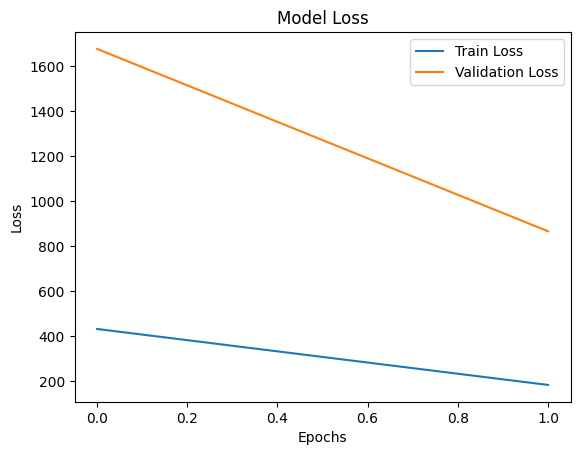

In [ ]:
#Plot the model keys - plot the loss for both training and validation
#Loss for training and validation went down
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train Loss', 'Validation Loss'], loc = 'upper right')
plt.show()

# Part 2: Facial Expression Detection
In the previous section, we trained a regression type model to detect the x and y coordinates of key facial features.

In this section, we will train a model to take images as input and classify people's emotions. We have data that contains images belonging to 5 categories:
1. 0 = Anger
2. 1 = Disgust
3. 2 = Sad
4. 3 = Happy
5. 4 = Surprise

This is a classification problem, classifying people's expressions into 5 categories.

Our input images will be of 48x48 pixels. Our classifier, a deep learning model, will feed in the images and classify the facial expressions into their corresponding emotion categories.

# Import Dataset and Perform Exploratory Data Analysis

In [ ]:
#load the dataset
expression = pd.read_csv('/content/icml_face_data.csv')
expression.head()
#This is pretty straightforward data. Every row indicates an image along with their corresponding expressions

emotion                                             pixels
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        0  151 150 147 155 148 133 111 140 170 174 182 15...
2        2  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
3        2  20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...
4        3  77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...

In [ ]:
#checking the format of the string in the pixels column
expression.columns = expression.columns.str.strip()
expression['pixels'][0]

'70 80 82 72 58 58 60 63 54 58 60 48 89 115 121 119 115 110 98 91 84 84 90 99 110 126 143 153 158 171 169 172 169 165 129 110 113 107 95 79 66 62 56 57 61 52 43 41 65 61 58 57 56 69 75 70 65 56 54 105 146 154 151 151 155 155 150 147 147 148 152 158 164 172 177 182 186 189 188 190 188 180 167 116 95 103 97 77 72 62 55 58 54 56 52 44 50 43 54 64 63 71 68 64 52 66 119 156 161 164 163 164 167 168 170 174 175 176 178 179 183 187 190 195 197 198 197 198 195 191 190 145 86 100 90 65 57 60 54 51 41 49 56 47 38 44 63 55 46 52 54 55 83 138 157 158 165 168 172 171 173 176 179 179 180 182 185 187 189 189 192 197 200 199 196 198 200 198 197 177 91 87 96 58 58 59 51 42 37 41 47 45 37 35 36 30 41 47 59 94 141 159 161 161 164 170 171 172 176 178 179 182 183 183 187 189 192 192 194 195 200 200 199 199 200 201 197 193 111 71 108 69 55 61 51 42 43 56 54 44 24 29 31 45 61 72 100 136 150 159 163 162 163 170 172 171 174 177 177 180 187 186 187 189 192 192 194 195 196 197 199 200 201 200 197 201 137 58 98 92

In [ ]:
#Create a function that converts the string format to an array - to be used for the strings in the pixels column
def string_to_array(string):
  return np.array(string.split(' ')).reshape(48,48, 1).astype('float32')

In [ ]:
#Create another function to resize images from (48, 48) to (96, 96) to make both models trained on the same image size. Evntually, we want to send one image to both models and both models should work.
def resize(image_input):
  image = image_input.reshape(48, 48)
  #using cubic interpolation between pixels
  return cv2.resize(image, dsize = (96, 96), interpolation = cv2.INTER_CUBIC)

In [ ]:
#Applying both of these functions in the dataset
expression['pixels'] = expression['pixels'].apply(lambda x: string_to_array(x))
expression['pixels'] = expression['pixels'].apply(lambda x: resize(x))

In [ ]:
expression.head()
#We have converted the strings to arrays and done resizing of the pixels

emotion                                             pixels
0        0  [[69.316925, 73.03865, 79.13719, 84.17186, 85....
1        0  [[151.09435, 150.91393, 150.65791, 148.96367, ...
2        2  [[23.061905, 25.50914, 29.47847, 33.99843, 36....
3        2  [[20.083221, 19.079437, 17.398712, 17.158691, ...
4        3  [[76.26172, 76.54747, 77.001785, 77.7672, 78.4...

In [ ]:
expression.shape

(24568, 2)

In [ ]:
#checking for null elements
#We have no null values, so that is good
expression.isnull().sum()

emotion    0
pixels     0
dtype: int64

In [ ]:
#we are creating some sort of dictionary to indicate the expressions based on labeled numbers
labels = {0:'anger', 1:'disgust', 2:'sad', 3:'happy', 4:'surprise'}

First image:


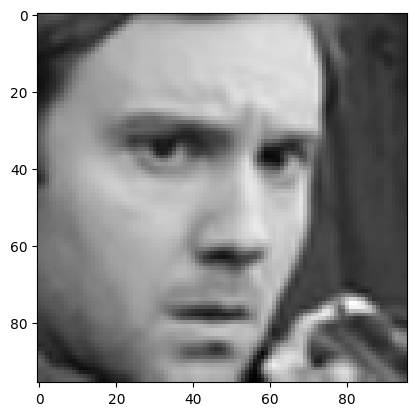

In [ ]:
#visualizing the first image as sample
print("First image:")
plt.imshow(expression['pixels'][0], cmap='gray')
#Resolution is poor because we interpolated between pixels and zoomed in (increased pixel dimension)

# Visualize Images and Plot Labels for Expression Detection

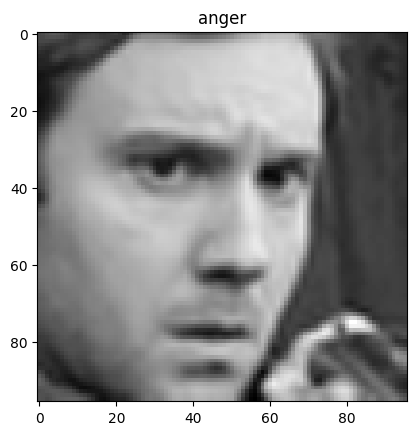

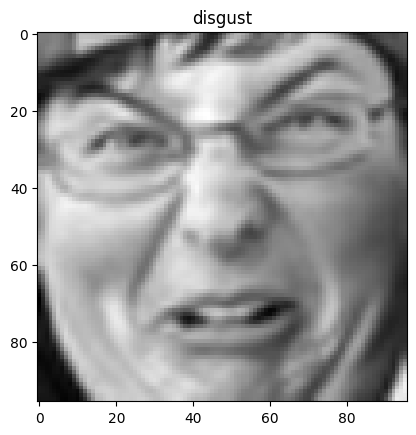

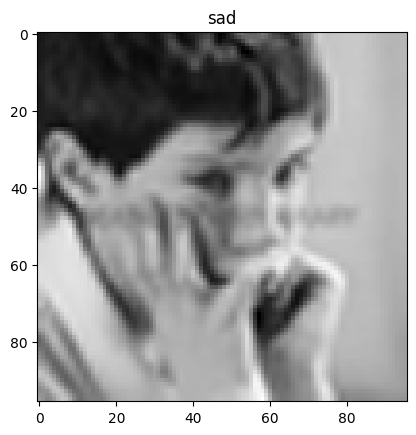

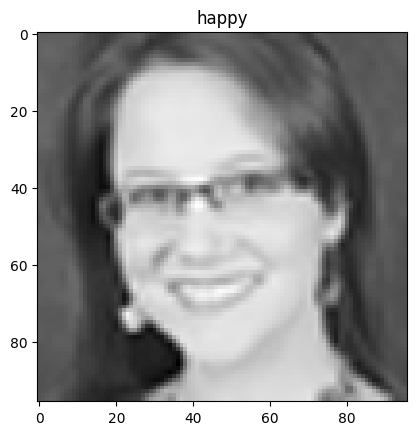

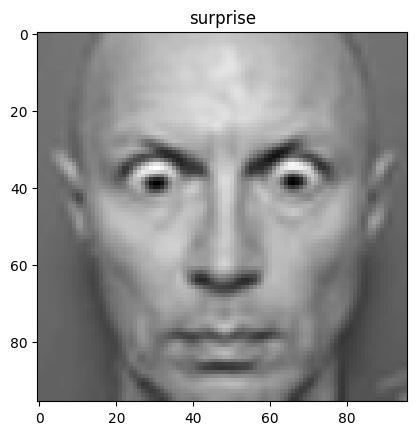

In [ ]:
#Performing a sanity check, displaying one image per emotion
emotions = [0, 1, 2, 3, 4]
for i in emotions:
  data = expression[expression['emotion'] == i][:1]
  image = data['pixels'].item()
  image = image.reshape(96, 96)
  plt.figure()
  plt.title(labels[i])
  plt.imshow(image, cmap='gray')
  plt.show()

MINI CHALLENGE: Plot bar chart to outline how many samoles (images) are present per emotion. This would help us assess how balanced the dataset is with respect to each emotion

In [ ]:
expression['emotion'].value_counts()

emotion
3    8989
2    6077
0    4953
4    4002
1     547
Name: count, dtype: int64

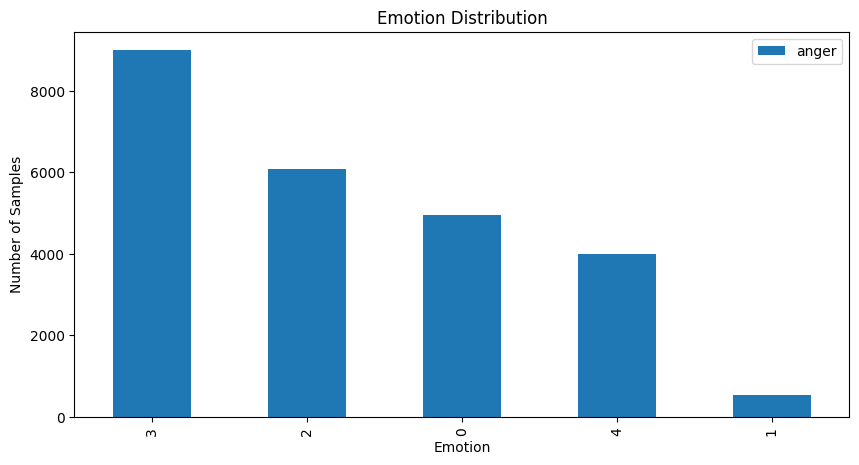

In [ ]:
plt.figure(figsize = (10, 5))
expression['emotion'].value_counts().plot(kind = 'bar')
plt.title('Emotion Distribution')
plt.xlabel('Emotion')
plt.ylabel('Number of Samples')
plt.legend(labels = labels.values())
plt.show()
#We have a pretty unbalanced dataset

<Axes: xlabel='emotion', ylabel='count'>

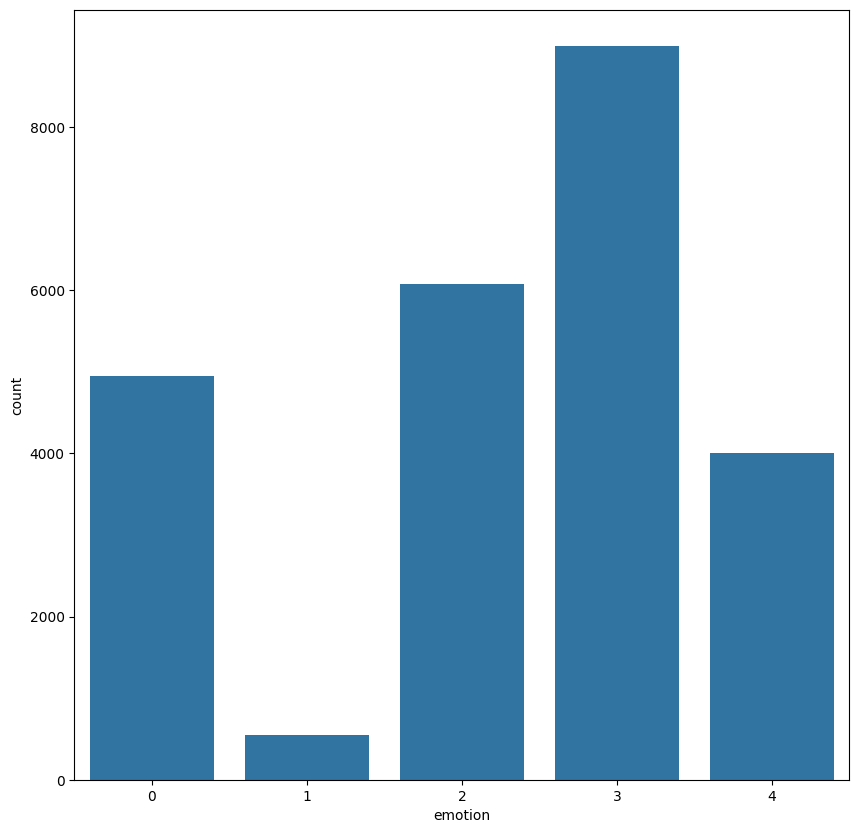

In [ ]:
#Using seaborn for the same task above:
plt.figure(figsize = (10,10))
sns.barplot(x = expression['emotion'].value_counts().index, y = expression['emotion'].value_counts())
#We have a pretty unbalanced dataset

To increase the number of samples in classes with not enough data, we can perform image augmentation (for example, rotate the pictures or increase their brightness).

# Perform Data Preparation and Image Augmentation

In [ ]:
#Divide the data into inputs (X) and outputs (y)
from keras.utils import to_categorical
X = expression['pixels']
y = to_categorical(expression['emotion'])

In [ ]:
X
#Here, we have over 24000 images. The actual pixels are represented as arrays for each image. So, we have multiple arrays for each image, for multiple images.
#To resolve this issue, we will use np.stack

0        [[69.316925, 73.03865, 79.13719, 84.17186, 85....
1        [[151.09435, 150.91393, 150.65791, 148.96367, ...
2        [[23.061905, 25.50914, 29.47847, 33.99843, 36....
3        [[20.083221, 19.079437, 17.398712, 17.158691, ...
4        [[76.26172, 76.54747, 77.001785, 77.7672, 78.4...
                               ...                        
24563    [[-4.901001, 5.6496277, 22.477203, 49.366516, ...
24564    [[181.71645, 179.72063, 176.40785, 175.93037, ...
24565    [[178.1166, 176.83118, 174.74146, 172.61276, 1...
24566    [[16.883408, 16.953583, 17.081573, 16.53476, 1...
24567    [[30.199814, 29.574478, 28.545822, 27.846603, ...
Name: pixels, Length: 24568, dtype: object

In [ ]:
y

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [ ]:
X = np.stack(X, axis = 0)

X = X.reshape(len(X), 96, 96, 1) #1 indicates 1 color channel - grayscale
print(X.shape, y.shape)

(24568, 96, 96, 1) (24568, 5)


In [ ]:
#Split the data into training, validation, and test datasets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.4, shuffle = True)

In [ ]:
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)
print(X_train.shape, y_train.shape)

(7862, 96, 96, 1) (7862, 5)
(4914, 96, 96, 1) (4914, 5)
(11792, 96, 96, 1) (11792, 5)


In [ ]:
#Normalization for image preprocessing for training, testing, and validation data
X_train = X_train/255.
X_test = X_test/255.
X_val = X_val/255.

In [ ]:
X_train

array([[[[0.83265334],
         [0.8182657 ],
         [0.7980281 ],
         ...,
         [0.12726715],
         [0.1310049 ],
         [0.13333334]],

        [[0.84163934],
         [0.826161  ],
         [0.80443335],
         ...,
         [0.1293387 ],
         [0.13325632],
         [0.13569085]],

        [[0.85666007],
         [0.8393201 ],
         [0.8150359 ],
         ...,
         [0.13256268],
         [0.13684005],
         [0.13948676]],

        ...,

        [[0.33756763],
         [0.38457462],
         [0.46198347],
         ...,
         [0.19615269],
         [0.19629402],
         [0.19633956]],

        [[0.31454682],
         [0.37426567],
         [0.47289753],
         ...,
         [0.17956273],
         [0.18343152],
         [0.18568546]],

        [[0.30030242],
         [0.3678393 ],
         [0.4795223 ],
         ...,
         [0.169513  ],
         [0.17567097],
         [0.17928222]]],


       [[[0.3493213 ],
         [0.34829915],
         [0.34

In [ ]:
#We want to create more images to perform image augmentation. We did manual image augmentation in section 1, but we would use ImageDateGenerator to do this automatically for us.
#Brightness range less than 1 darken the image, numbers larger than 1 brighten the image. Here, we will brighten the image for image augmentation.
training_data_aug = ImageDataGenerator(rotation_range = 15, width_shift_range = 0.1, height_shift_range = 0.1, shear_range = 0.1, zoom_range = 0.1,
                                       horizontal_flip = True, vertical_flip = True, fill_mode = "nearest", brightness_range = [1.1, 1.5])

# Build and Train Deep Learning Model for Facial Expression Classification

In [ ]:
input_shape = (96, 96, 1)

# Input tensor shape
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3,3))(X_input)

# First stage
X = Conv2D(64, (7,7), strides= (2,2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides= (2,2))(X)

# Second stage
X = res_block(X, filter= [64,64,256], stage= 2)

# Third stage
X = res_block(X, filter= [128,128,512], stage= 3)

# Fourth stage
#X = res_block(X, filter = [256, 256, 1024], stage = 4)

# Average Pooling
X = AveragePooling2D((4,4), name = 'Averagea_Pooling')(X)

# Final layer
#Dropout is a regularization technique to ensure the generalization capability of the network. As the network is trained, a certain percentage of the neurons are dropped so that the actual network advoids interdependencies between the neurons
X = Flatten()(X)
X = Dense(5, activation = 'softmax', name = 'Dense_final', kernel_initializer = glorot_uniform(seed = 0))(X) #number of outputs = 5 for the 5 emotions - so which of these 5 emotions will have the highest probability? As a resultm we use a softmax activation function
model_2_emotion = tf.keras.Model(inputs = X_input, outputs = X, name = 'Resnet18')
model_2_emotion.summary()


Model: "Resnet18"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 96, 96, 1)]          0         []                            
                                                                                                  
 zero_padding2d_3 (ZeroPadd  (None, 102, 102, 1)          0         ['input_4[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1 (Conv2D)              (None, 48, 48, 64)           3200      ['zero_padding2d_3[0][0]']    
                                                                                                  
 bn_conv1 (BatchNormalizati  (None, 48, 48, 64)           256       ['conv1[0][0]']        

In [ ]:
#compile the model using Adam optimizer to train the network
model_2_emotion.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
#Our first facial features model was saved in two forms: model_1_facialFeatures.h5 and model_1_facialFeatures.json
#We will use early stopping to terminate and exit training if validation loss is not decreasing even after a fixed number of epochs.
#If the loss on the validation dataset is going up but that of the training dataset is going down, then the model is overfitting the data. if it happens for one epoch, then that is fine. But for more than 20 epochs, we will use early stopping
early_stopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 20)

#we will once again save the best model with the lower validation loss.
checkpointer = ModelCheckpoint(filepath = 'model_2_emotion.hdf5', verbose = 1, save_best_only = True)

In [ ]:
#Fit the model
history = model_2_emotion.fit(training_data_aug.flow(X_train, y_train, batch_size = 64), validation_data = (X_val, y_val),
                              epochs = 2, steps_per_epoch= len(X_train)//64,
                              callbacks = [early_stopping, checkpointer])

Epoch 1/2
184/184 [==============================] - ETA: 0s - loss: 1.5706 - accuracy: 0.3469
Epoch 1: val_loss improved from inf to 1.47573, saving model to model_2_emotion.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


184/184 [==============================] - 336s 2s/step - loss: 1.5706 - accuracy: 0.3469 - val_loss: 1.4757 - val_accuracy: 0.3684
Epoch 2/2
184/184 [==============================] - ETA: 0s - loss: 1.4317 - accuracy: 0.3736
Epoch 2: val_loss improved from 1.47573 to 1.44535, saving model to model_2_emotion.hdf5
184/184 [==============================] - 330s 2s/step - loss: 1.4317 - accuracy: 0.3736 - val_loss: 1.4453 - val_accuracy: 0.2455


In [ ]:
#save the model architecture as a json file:
model_json = model_2_emotion.to_json()
with open("model_2_emotion.json", "w") as json_file:
    json_file.write(model_json)

# Assess the Performance of Trained Facial Expression Classifier Model
Here, we would load a pre-trained model that performs the best.

In [ ]:
with open('emotion.json', 'r') as json_file:
  json_savedModel = json_file.read()

#Loading this pre-trained model:
model_2_expression = tf.keras.models.model_from_json(json_savedModel)
#The weights weights_keypoint.hdf5 are the weights for the pre-trained best model
model_2_expression.load_weights('weights_emotions.hdf5')
model_2_expression.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
#Getting the test accuracy of the model - around 87%, which is very good
score = model_2_expression.evaluate(X_test, y_test)
print("Test accuracy: {}".format(score[1]))

154/154 [==============================] - 26s 163ms/step - loss: 0.3397 - accuracy: 0.8759
Test accuracy: 0.8758648633956909


In [ ]:
#Get the parameters/keys of the evaluated score
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
#Getting performance KPIs:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

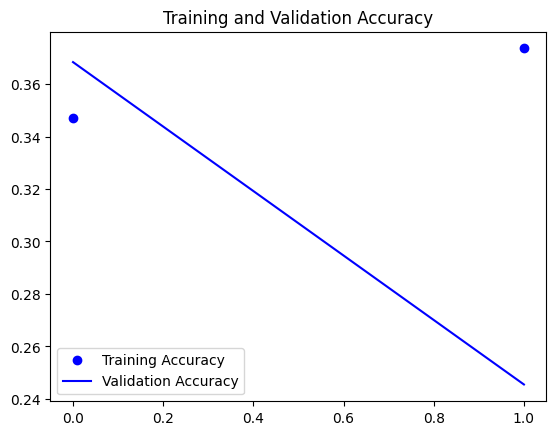

In [ ]:
#Printing these performance KPIs in a graph:
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

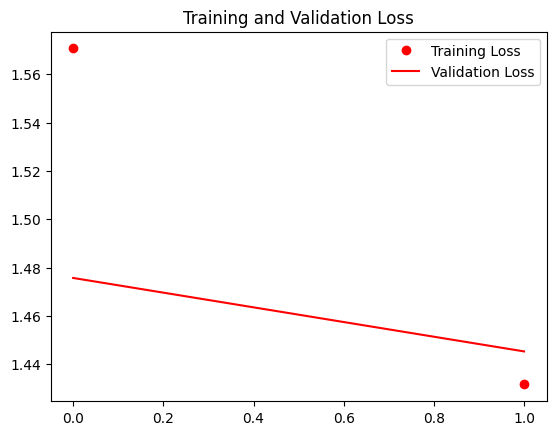

In [ ]:
#Plotting the loss:
plt.plot(epochs, loss, 'ro', label = 'Training Loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

In [ ]:
#Get the actual predictions from the model
predicted_emotions = np.argmax(model_2_expression.predict(X_test), axis = -1)
y_true = np.argmax(y_test, axis = -1)

154/154 [==============================] - 25s 163ms/step


In [ ]:
y_true.shape #around 1200 samples for testing data set

(4914,)

<Axes: >

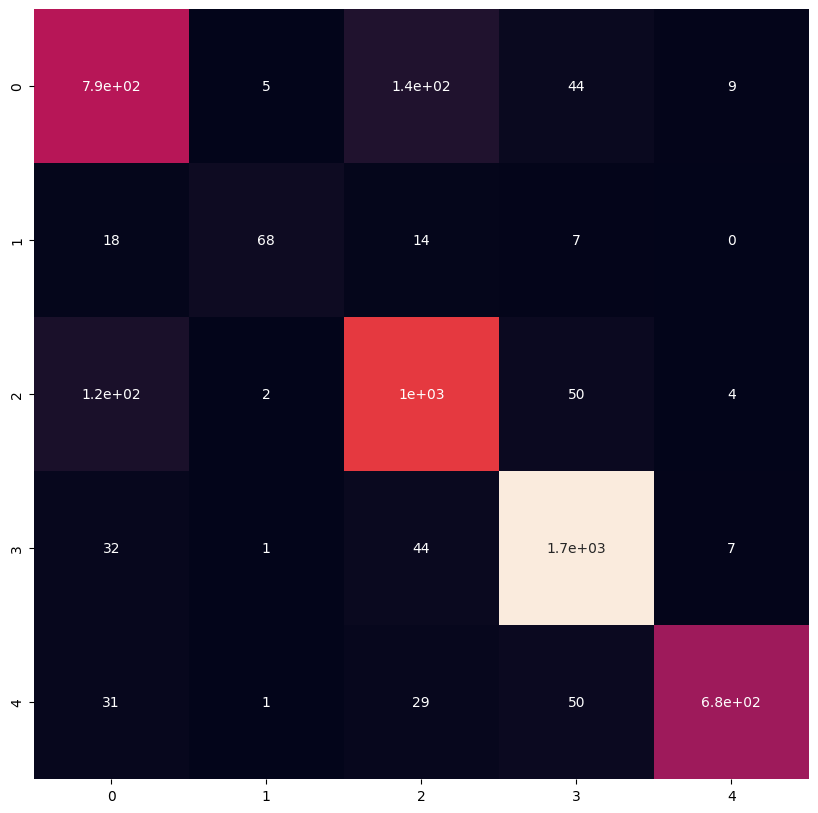

In [ ]:
#make a confusion matrix for y_true and predicted_emotions
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, predicted_emotions)
#use a heatmap to depict the confusion matrix
plt.figure(figsize = (10,10))
sns.heatmap(cm, annot = True, cbar = False)
#The model predictions (denoted by the slanting boxes) are matching the true samples as per this heatmap.

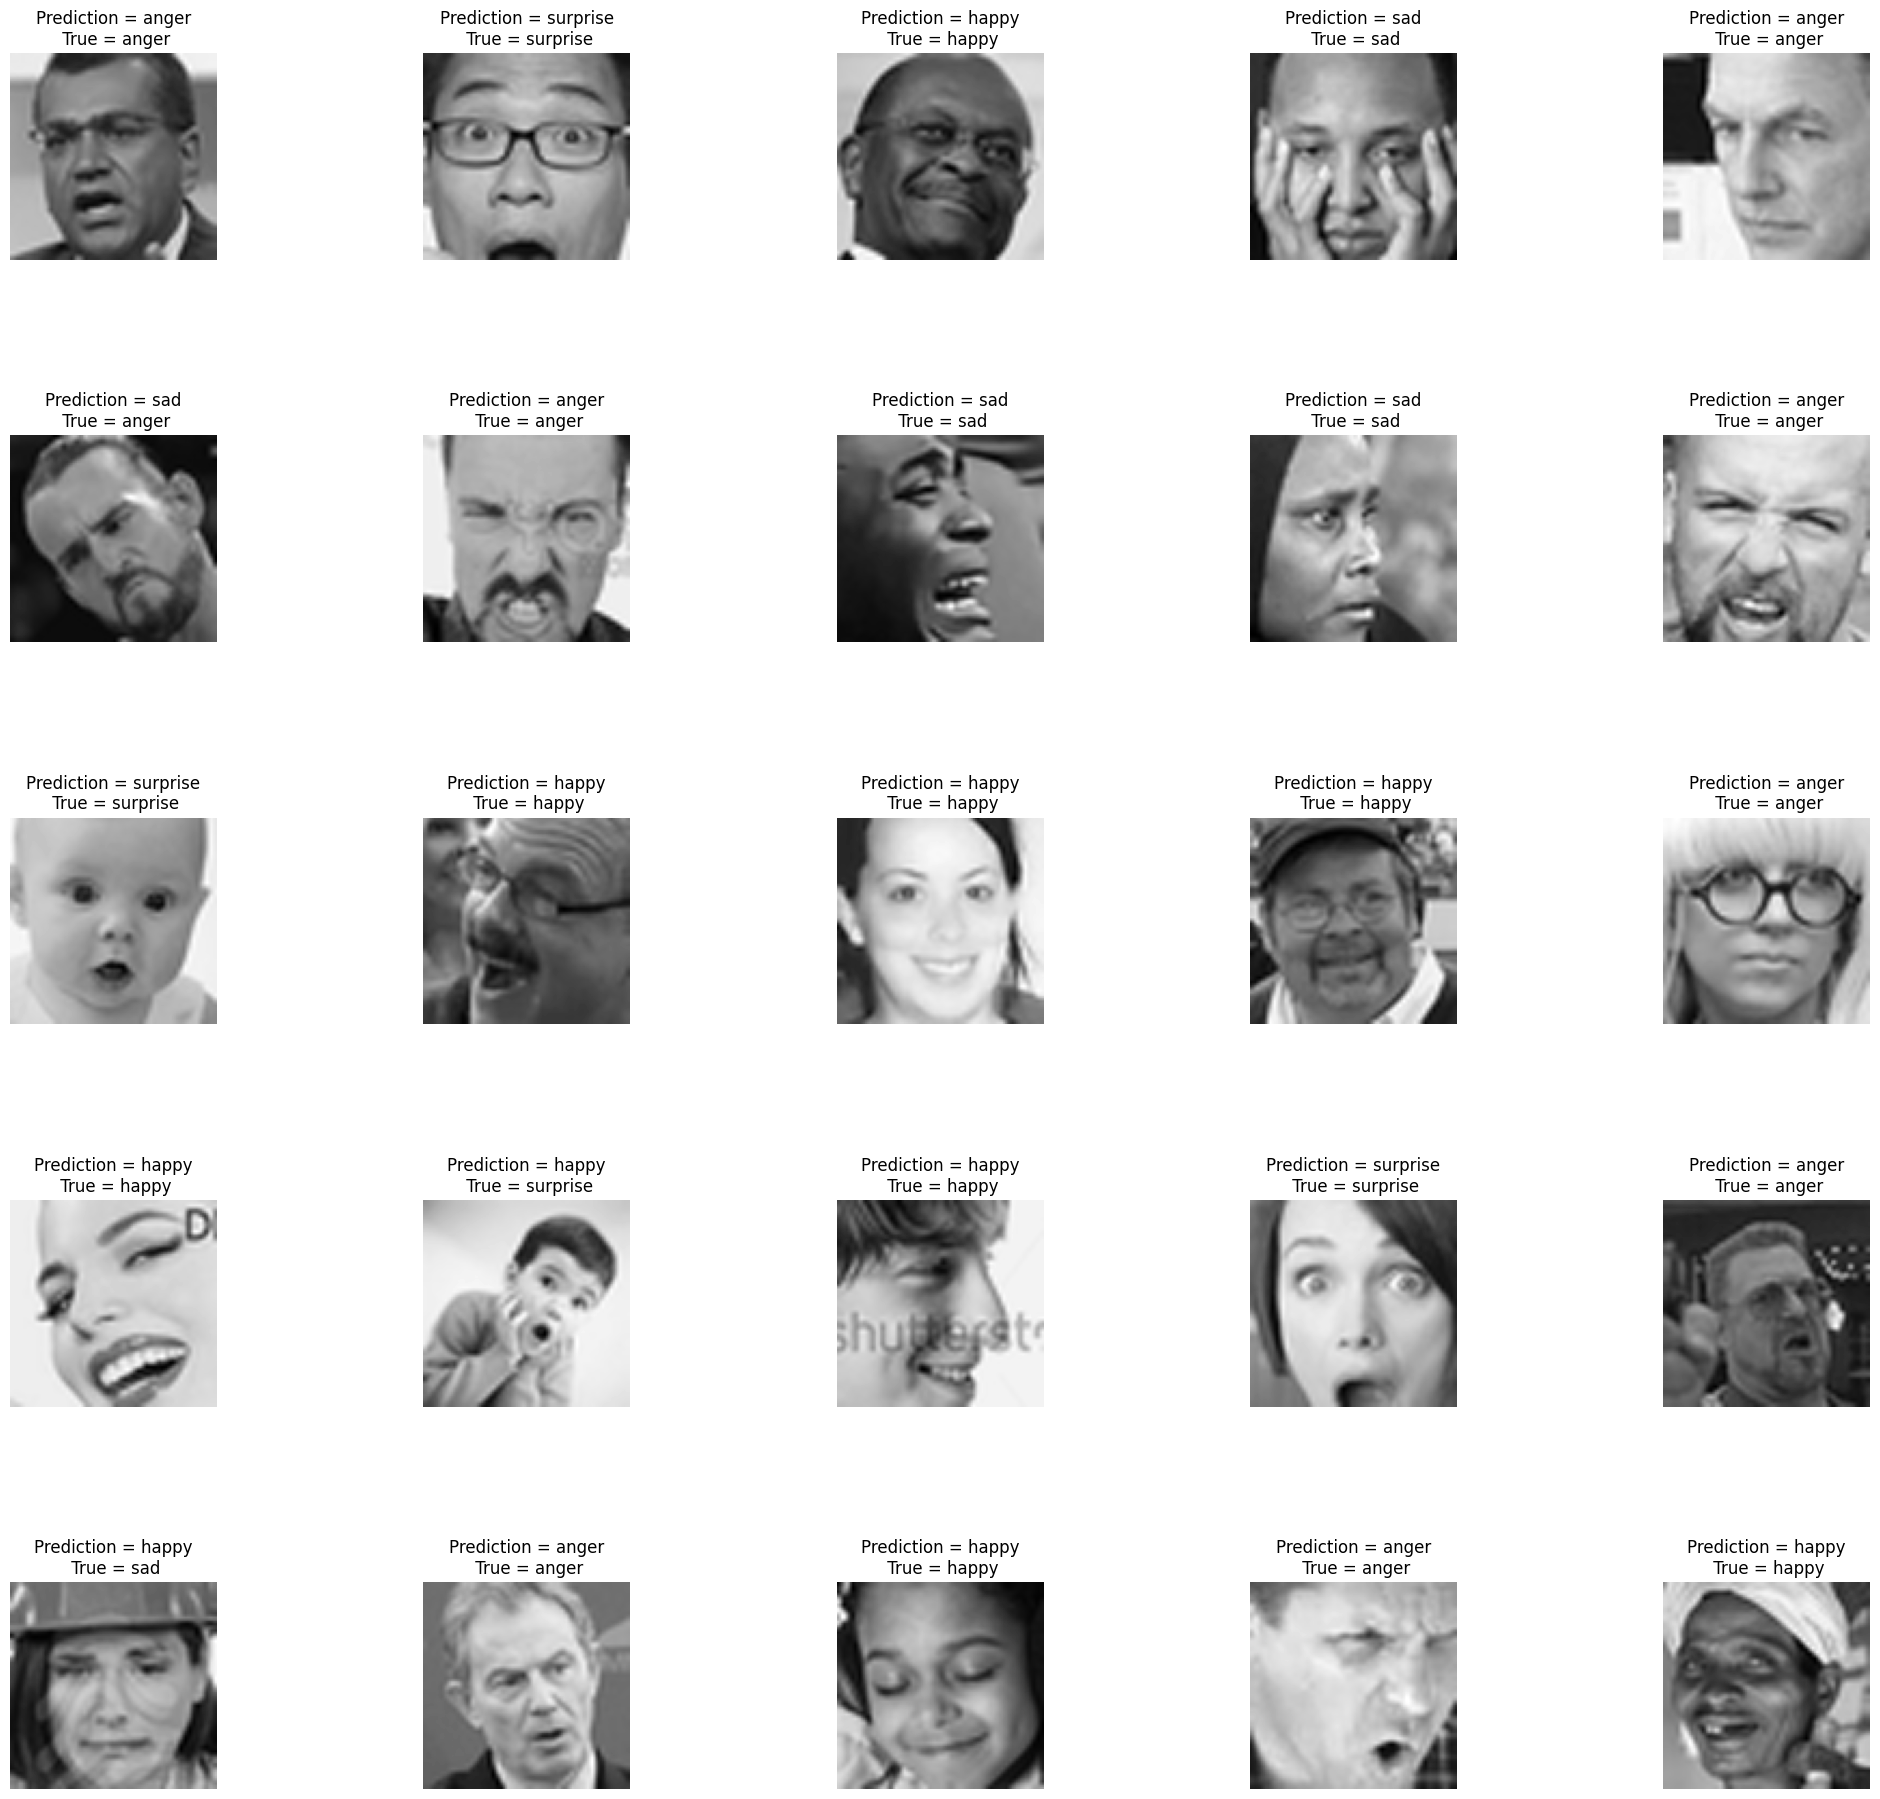

In [ ]:
#Print out the grid of 25 images along with their predicted/trye labels
fig, axes = plt.subplots(5, 5, figsize = (24, 24))
axes = axes.ravel()

for i in np.arange(0, 25):
  axes[i].imshow(X_test[i].reshape(96, 96), cmap = 'gray')
  axes[i].set_title("Prediction = {}\n True = {}".format(labels[predicted_emotions[i]], labels[y_true[i]]))
  axes[i].axis('off')
plt.subplots_adjust(wspace = 1)

In [ ]:
#Print out classification report and analyze precision and recall
from sklearn.metrics import classification_report
print(classification_report(y_true, predicted_emotions))
#For class 1, the recall is terrible (0.61). This also has the least f1-score, which is the harmonic mean between precision and recall.
#The problem with class 1 may be the fact that it has a very small number of images, as opposed to the other classes. So, to overcome this, we can do specific image augmentation for that class or increase the number of samples in that class.

              precision    recall  f1-score   support

           0       0.80      0.80      0.80       989
           1       0.88      0.64      0.74       107
           2       0.82      0.85      0.84      1199
           3       0.92      0.95      0.94      1826
           4       0.97      0.86      0.91       793

    accuracy                           0.88      4914
   macro avg       0.88      0.82      0.84      4914
weighted avg       0.88      0.88      0.88      4914



#Part 3: Combining Both Models - Facial Feature Coordinates Detection and Facial Expression Emotion Classification Models

In [ ]:
#Making two predictions - from the facial feature keypoint model, and from the emotion model
def predict(test_data):
  df_prediction = model_1_facialFeatures.predict(test_data)
  df_emotion = np.argmax(model_2_expression.predict(test_data), axis = -1)
  #Reshaping array from (4914,) to (4914, 1)
  df_emotion = np.expand_dims(df_emotion, axis = 1)
  #converting the predictions of df_prediction into a dataframe
  df_prediction = pd.DataFrame(df_prediction)
  #Adding the emotions predictions to the df_prediction dataset
  df_prediction['emotions'] = df_emotion

  #As a result, we have consolidated the predictions from the two models into a single dataframe

  return df_prediction


In [ ]:
#Get combined predictions using these models
df_prediction = predict(X_test)
df_prediction.head()

154/154 [==============================] - 28s 184ms/step


0          1          2          3          4          5  \
0  64.128952  37.285492  31.324364  38.852657  58.172615  38.214855   
1  55.845024  38.115265  41.366680  39.160080  52.665928  39.274456   
2  48.694748  38.594135  52.378239  39.039322  49.341339  38.872410   
3  36.556759  41.401295  55.842594  40.765030  40.038803  41.870155   
4  64.133369  36.556496  30.697996  35.862926  56.390522  37.612385   

           6          7          8          9  ...         21         22  \
0  69.891846  37.722324  36.838711  39.101837  ...  55.465851  62.425343   
1  58.778358  38.982952  43.965748  39.612816  ...  59.104164  54.257515   
2  47.924278  39.867146  51.606701  39.004593  ...  46.993767  45.142895   
3  33.004192  42.396561  52.128914  41.354759  ...  60.488224  36.904465   
4  71.418076  37.301769  36.389095  37.064781  ...  62.032364  61.315228   

          23         24         25         26         27         28  \
0  73.763611  33.833035  74.565460  47.546806  70.778809  47.688263   
1  82.499146  42.757832  82.875168  48.172920  78.783188  48.149639   
2  72.662392  47.648006  72.872322  46.500443  65.959961  45.738674   
3  77.850609  54.714390  77.786224  45.727367  76.363266  45.948277   
4  78.978912  34.143585  77.474304  43.895077  79.770309  44.184776   

          29  emotions  
0  79.790230         0  
1  84.630524         4  
2  75.097061         3  
3  85.160110         2  
4  80.249084         0  

[5 rows x 31 columns]

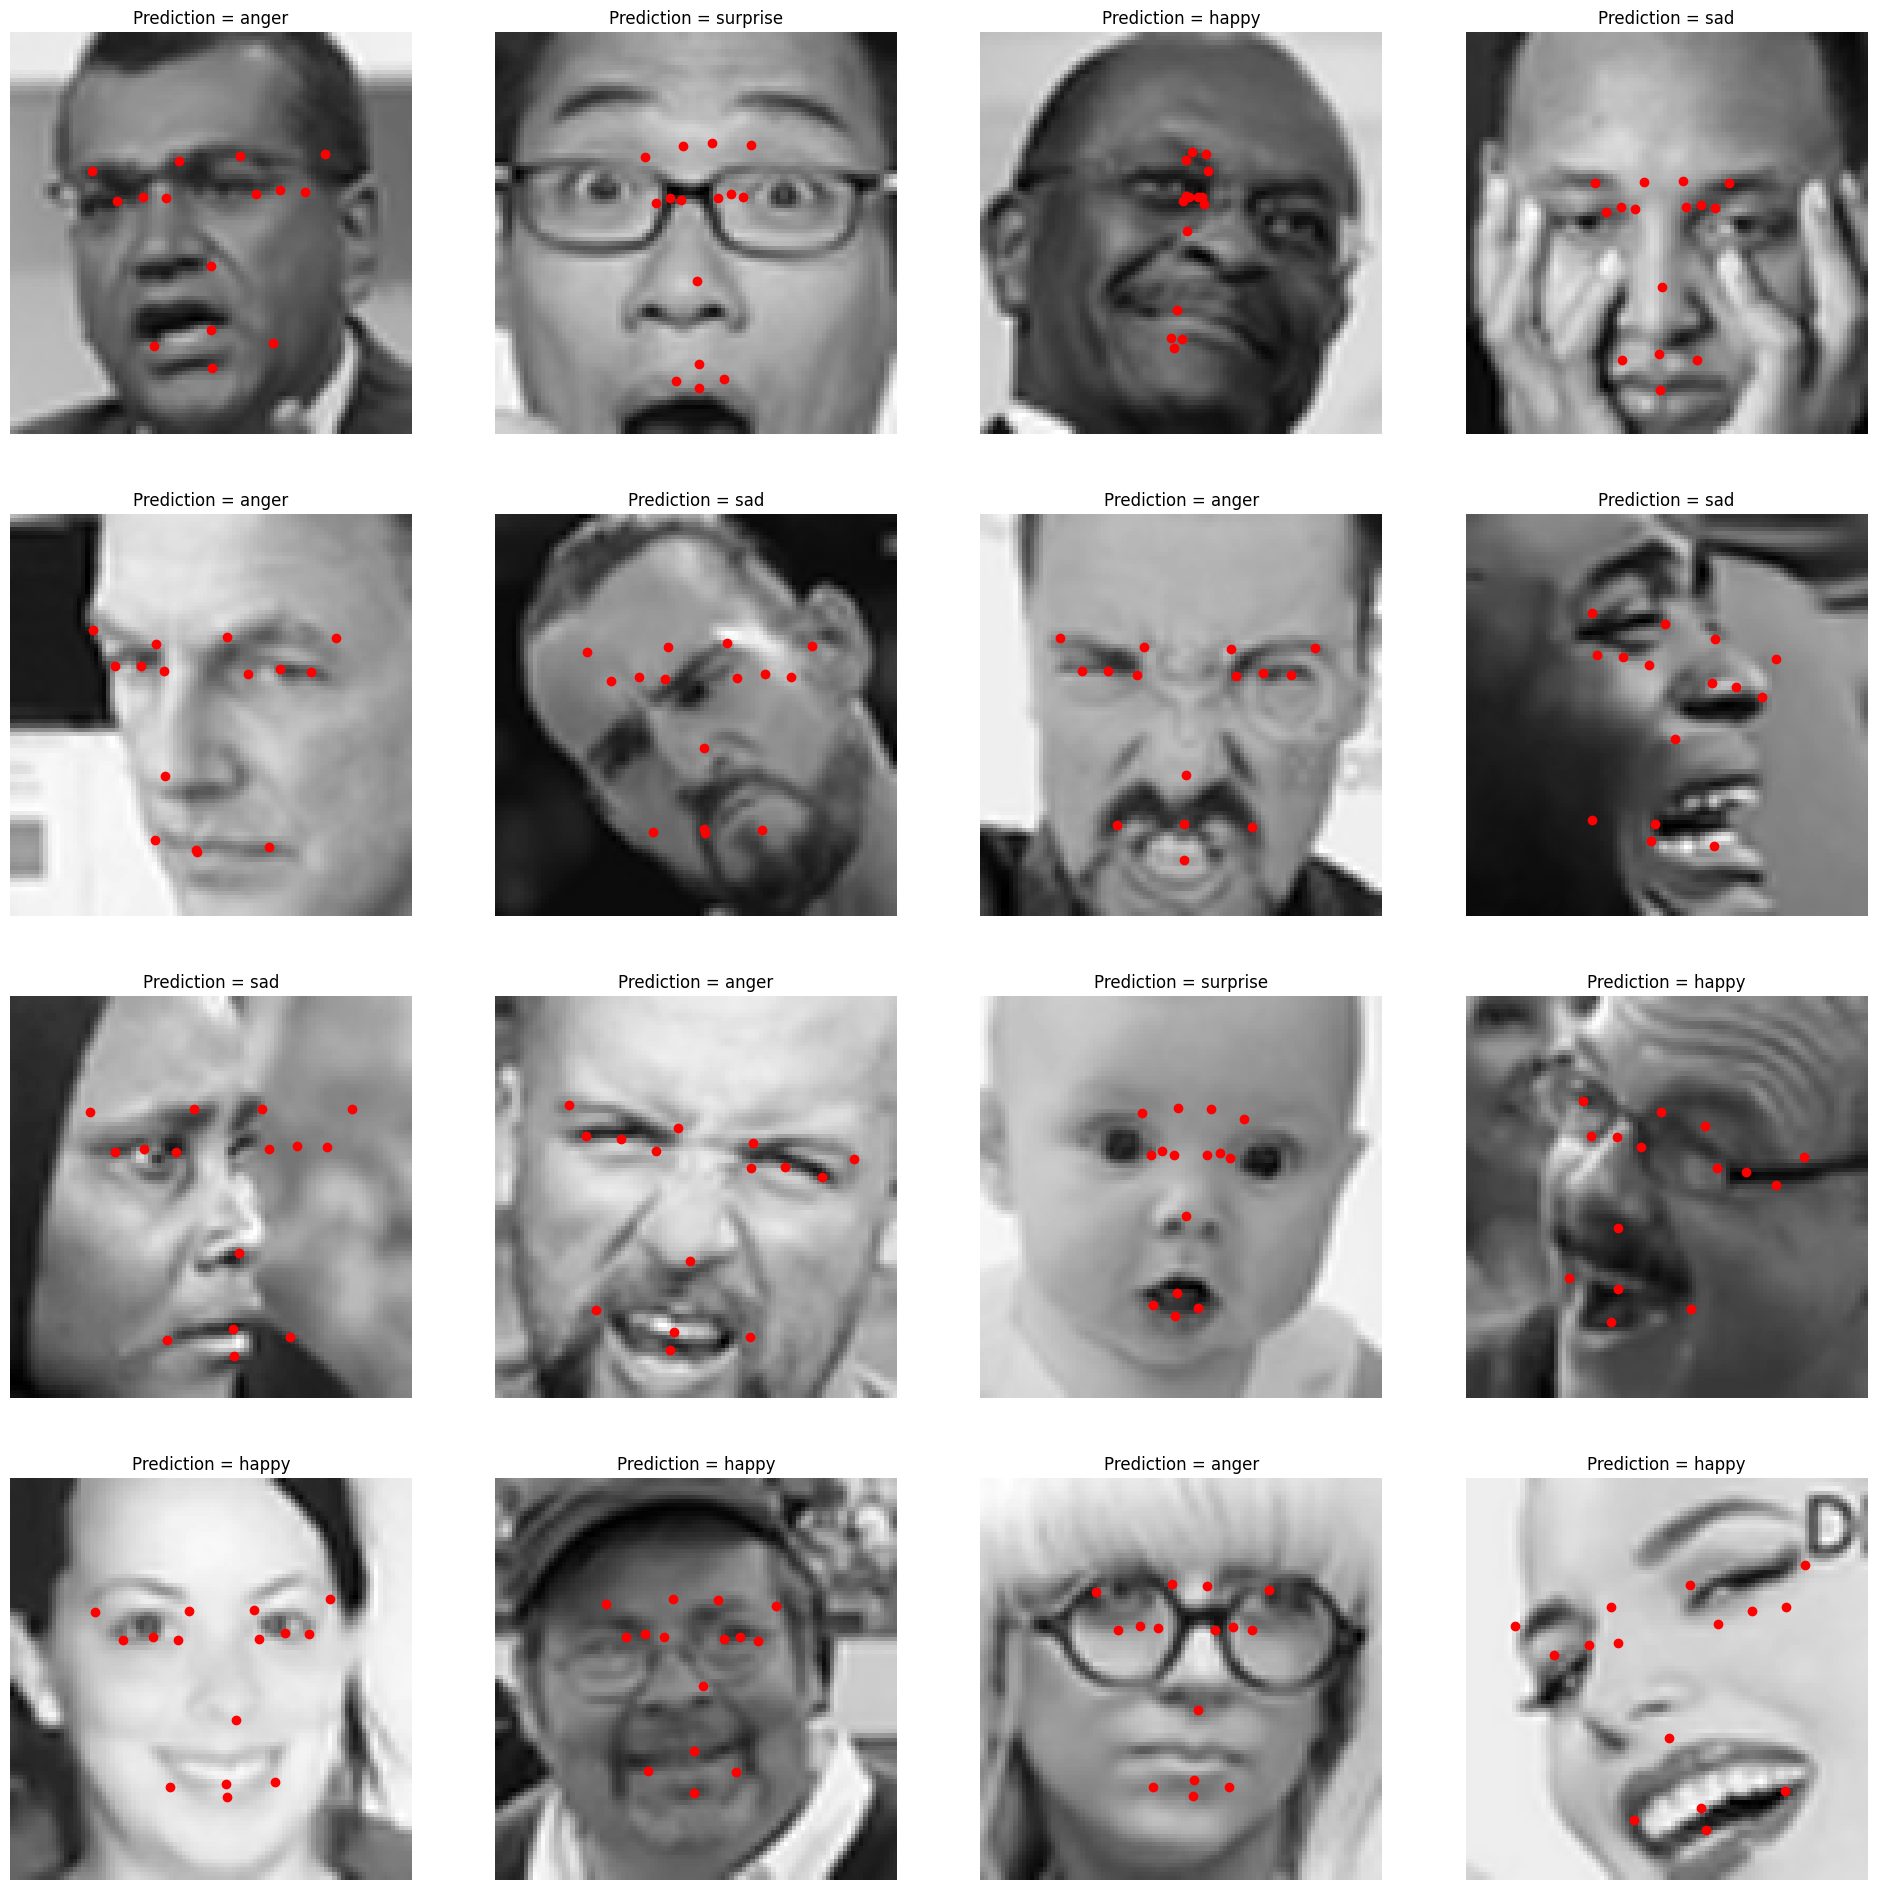

In [ ]:
#Plot a grid of 16 images along with their predicted emotions and key points and real emotions and key points
#Print out the grid of 25 images along with their predicted/trye labels
fig, axes = plt.subplots(4, 4, figsize = (24, 24))
axes = axes.ravel()

for i in np.arange(16):
  axes[i].imshow(X_test[i].squeeze().astype(np.float64), cmap = 'gray')
  axes[i].set_title("Prediction = {}".format(labels[df_prediction['emotions'][i]]))
  axes[i].axis('off')
  for j in range(1, 31, 2):
    axes[i].plot(df_prediction.loc[i][j-1], df_prediction.loc[i][j], 'ro')

# Finally, Deploy Both Models Using TensorFlow Serving
1. Assuming that we have trained our model and it is generating good results on the testing data, we will incorporate our trained TensorFlow model into a web application and deploy the model in a production level environment.
2. TensorFlow serving is an efficient serving system for machine learning models, specifically designed for production level environments.
3. We will save the model in a format suitable for TensorFlow Serving (with a verion number).
4. Once the model is deployed, we can also begin making inference requests to a model.

Required Parameters:
1. rest_api_port: used for REST requests.
2. model_name = used in the URL of REST requests. Any model name can be chosen.
3. model_base_path = path to the directory where model is saved.

In order to make predictions using TensorFlow Servings, we need to pass requests as a JSON object. We will perform this using the python requests library by parsing through the JSON object containing the image data, Finally, we will get the prediction from our inference request and use the argmax function to determine the predicted class.